In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
try:
    users_df = pd.read_csv('users.csv')
    friendships_df = pd.read_csv('friendships.csv')
    posts_df = pd.read_csv('posts.csv')
    interactions_df = pd.read_csv('interactions.csv')

    print("All datasets loaded successfully!")
    print("\nUsers Data Head:")
    print(users_df.head())
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please make sure the CSV files (users.csv, friendships.csv, posts.csv, interactions.csv) are in the same directory as the notebook.")

All datasets loaded successfully!

Users Data Head:
  Username  Age  Gender Ethnicity   Country
0   user_1   26  Female  Hispanic  Fictland
1   user_2   24  Female   African  Fictland
2   user_3   28  Female   African  Fictland
3   user_4   30   Other     Asian  Fictland
4   user_5   24    Male     Asian  Fictland


In [3]:
# --- Ethical Data Aggregation: Create Age Groups ---
# Define age bins and labels
age_bins = [0, 18, 25, 35, 50, 100]
age_labels = ['0-18', '19-25', '26-35', '36-50', '51+']
users_df['AgeGroup'] = pd.cut(users_df['Age'], bins=age_bins, labels=age_labels, right=False)


# --- Merge DataFrames ---
# Merge posts with interactions
# The suffixes distinguish between the user who posted and the user who interacted
merged_df = pd.merge(posts_df, interactions_df, on='Post_ID', suffixes=('_post', '_interaction'))

# Merge the result with the users data to get demographics of the user who made the post
# We join on 'Username_post' from the merged_df and 'Username' from users_df
final_df = pd.merge(merged_df, users_df, left_on='Username_post', right_on='Username', how='left')


print("\nMerged DataFrame Head:")
print(final_df.head())


Merged DataFrame Head:
  Post_ID Username_post      Post_Content              Timestamp_post  \
0  post_1       user_48  Had a great day!  2022-09-21 09:06:07.946897   
1  post_1       user_48  Had a great day!  2022-09-21 09:06:07.946897   
2  post_1       user_48  Had a great day!  2022-09-21 09:06:07.946897   
3  post_1       user_48  Had a great day!  2022-09-21 09:06:07.946897   
4  post_1       user_48  Had a great day!  2022-09-21 09:06:07.946897   

  Username_interaction Interaction_Type       Timestamp_interaction Username  \
0              user_30          comment  2022-10-27 00:52:07.946897  user_48   
1              user_54             like  2022-12-09 08:16:07.946897  user_48   
2              user_96            share  2023-01-31 10:46:07.946897  user_48   
3              user_52            share  2023-02-06 13:44:07.946897  user_48   
4               user_3             like  2023-03-30 09:30:07.946897  user_48   

   Age Gender Ethnicity   Country AgeGroup  
0   23  Oth

In [5]:
# --- Simple Sentiment Analysis ---
def get_sentiment(post_content):
    """
    A simple function to classify sentiment based on keywords.
    """
    positive_words = ['great', 'love', 'amazing', 'blessed']
    negative_words = ['down', 'sad', 'could be better']
    
    post_lower = str(post_content).lower()
    
    is_positive = any(word in post_lower for word in positive_words)
    is_negative = any(word in post_lower for word in negative_words)
    
    if is_positive and not is_negative:
        return 'Positive'
    elif is_negative and not is_positive:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis function to the 'Post_Content' column
final_df['Sentiment'] = final_df['Post_Content'].apply(get_sentiment)

print("\nDataFrame with Sentiment:")
print(final_df[['Post_Content', 'Sentiment']].head())


DataFrame with Sentiment:
       Post_Content Sentiment
0  Had a great day!  Positive
1  Had a great day!  Positive
2  Had a great day!  Positive
3  Had a great day!  Positive
4  Had a great day!  Positive


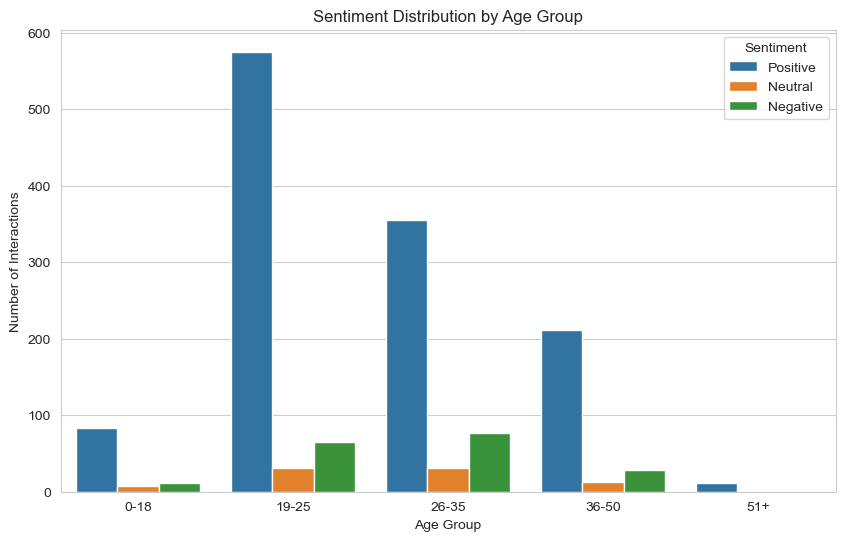

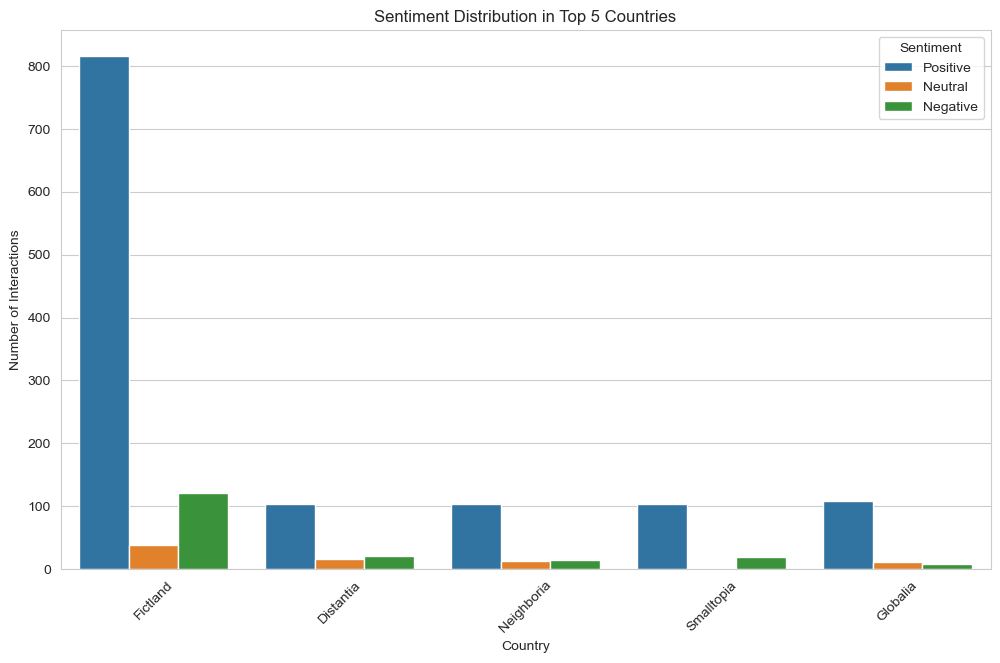

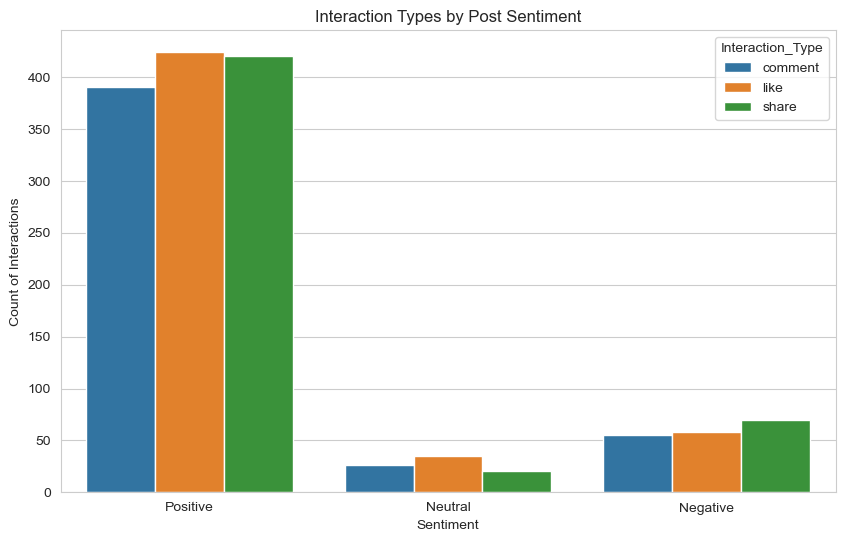

In [7]:
# Set the style for the plots
sns.set_style("whitegrid")

# --- Plot 1: Sentiment Distribution by Age Group ---
plt.figure(figsize=(10, 6))
sns.countplot(data=final_df, x='AgeGroup', hue='Sentiment', order=age_labels)
plt.title('Sentiment Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Interactions')
plt.show()

# --- Plot 2: Sentiment Distribution by Country ---
plt.figure(figsize=(12, 7))
# Getting the top 5 countries by number of interactions for better visualization
top_countries = final_df['Country'].value_counts().nlargest(5).index
sns.countplot(data=final_df[final_df['Country'].isin(top_countries)], x='Country', hue='Sentiment')
plt.title('Sentiment Distribution in Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.show()

# --- Plot 3: Interaction Types by Sentiment ---
plt.figure(figsize=(10, 6))
sns.countplot(data=final_df, x='Sentiment', hue='Interaction_Type')
plt.title('Interaction Types by Post Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count of Interactions')
plt.show()

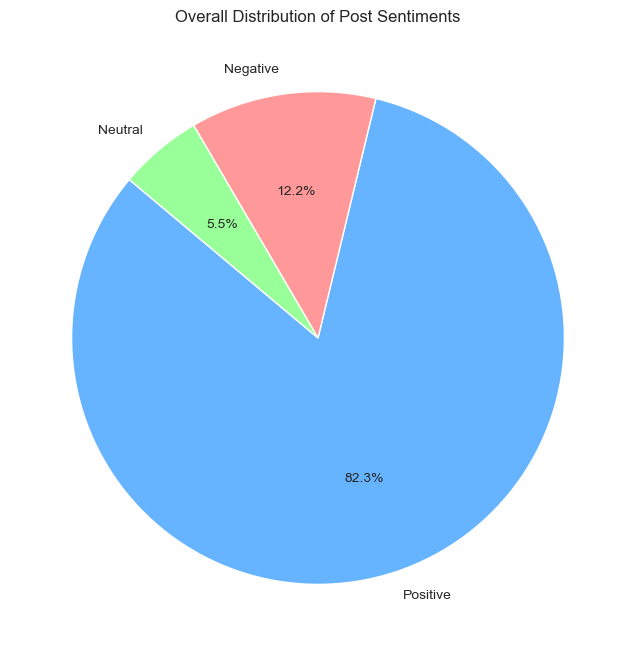

In [9]:
# --- Pie Chart 1: Overall Sentiment Distribution ---
# Calculate the counts for each sentiment category
sentiment_counts = final_df['Sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999','#99ff99'])
plt.title('Overall Distribution of Post Sentiments')
plt.ylabel('') # Hides the 'Sentiment' label on the y-axis
plt.show()

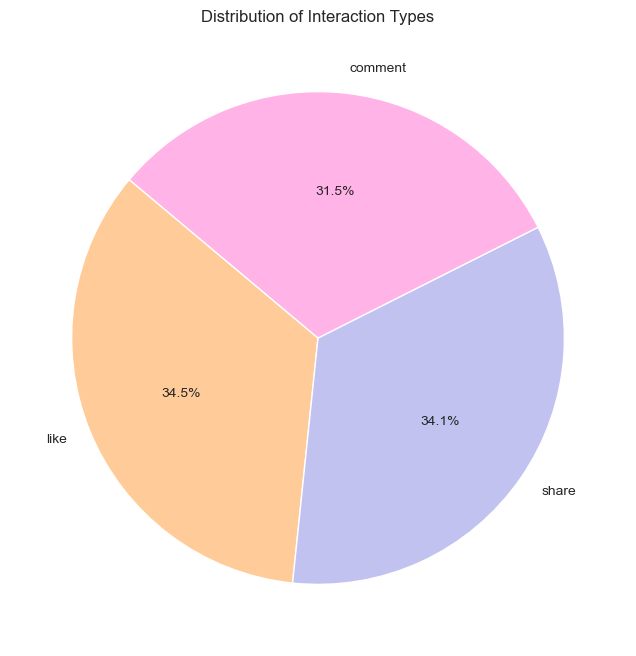

In [11]:
# --- Pie Chart 2: Interaction Type Distribution ---
# Calculate the counts for each interaction type
interaction_counts = final_df['Interaction_Type'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(interaction_counts, labels=interaction_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ffcc99','#c2c2f0','#ffb3e6'])
plt.title('Distribution of Interaction Types')
plt.ylabel('')
plt.show()

In [15]:
# --- Data Preparation for Scatter Plots ---
# Calculate the number of posts per user from the original posts_df
posts_per_user = posts_df.groupby('Username').size().reset_index(name='Post_Count')

# Calculate the number of interactions per user from the original interactions_df
interactions_per_user = interactions_df.groupby('Username').size().reset_index(name='Interaction_Count')

# Merge these counts with the users_df
user_activity_df = pd.merge(users_df, posts_per_user, on='Username', how='left')
user_activity_df = pd.merge(user_activity_df, interactions_per_user, on='Username', how='left')

# Replace NaN (for users with 0 posts or interactions) with 0
for col in user_activity_df.select_dtypes(["category"]).columns:
    user_activity_df[col] = user_activity_df[col].cat.add_categories([0]).fillna(0)

print("\nUser Activity Data Head:")
print(user_activity_df.head())


User Activity Data Head:
  Username  Age  Gender Ethnicity   Country AgeGroup  Post_Count  \
0   user_1   26  Female  Hispanic  Fictland    26-35           5   
1   user_2   24  Female   African  Fictland    19-25           4   
2   user_3   28  Female   African  Fictland    26-35           2   
3   user_4   30   Other     Asian  Fictland    26-35           4   
4   user_5   24    Male     Asian  Fictland    19-25           4   

   Interaction_Count  
0                 20  
1                 12  
2                 13  
3                  9  
4                 19  


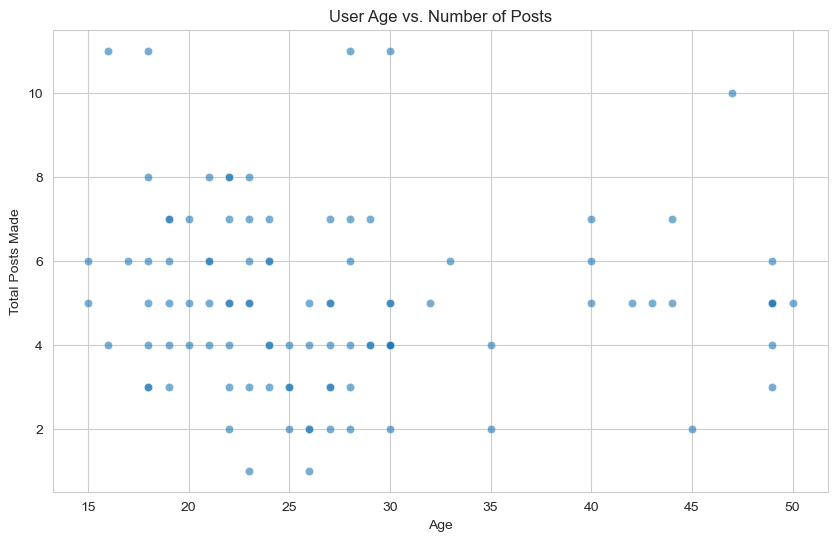

In [17]:
# --- Scatter Plot 1: Age vs. Number of Posts ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_activity_df, x='Age', y='Post_Count', alpha=0.6)
plt.title('User Age vs. Number of Posts')
plt.xlabel('Age')
plt.ylabel('Total Posts Made')
plt.show()

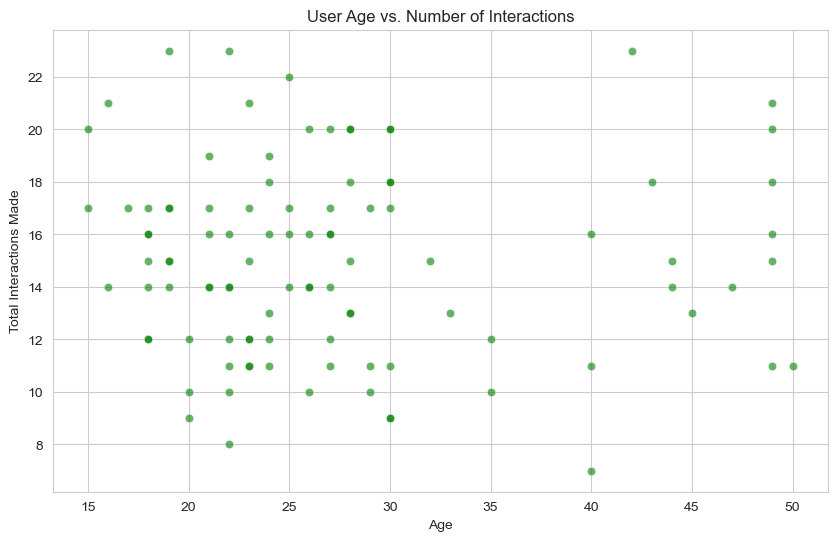

In [19]:
# --- Scatter Plot 2: Age vs. Number of Interactions ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_activity_df, x='Age', y='Interaction_Count', alpha=0.6, color='green')
plt.title('User Age vs. Number of Interactions')
plt.xlabel('Age')
plt.ylabel('Total Interactions Made')
plt.show()